In [1]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig
from torch._tensor import Tensor
import importlib

from src.GPVisualiser import GPVisualiserMatplotlib, get_obs_from_client
from botorch.models import SingleTaskGP

# Single prediction

## initialise response and client

In [2]:
simple_func = lambda x: sum(x)
resp = ResponseFunction(simple_func, 3)


## configure the search domain

In [3]:
client = Client()

In [4]:
# 2. Configure where Ax will search.
client.configure_experiment(
    name="booth_function",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(0, 20.0),
            parameter_type="float",
        ) for i in range(3)
    ],
)

In [5]:

client.configure_optimization(objective="booth")

In [6]:
for _ in range(20):

    for trial_index, parameters in client.get_next_trials(max_trials=1).items():
        coordinates = torch.tensor(
            [[parameters[f"x{i}"]] for i in range(3)], dtype=torch.float64
        )

        client.complete_trial(
            trial_index=trial_index,
            raw_data={
            "booth": resp.evaluate(coordinates)[0].item()
            },
        )

client.get_best_parameterization()

[INFO 09-17 13:25:35] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-17 13:25:35] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0, 'x2': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-17 13:25:35] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-17 13:25:35] ax.api.client: Generated new trial 1 with parameters {'x0': 11.965692, 'x1': 17.571725, 'x2': 11.600214} using GenerationNode Sobol.
[INFO 09-17 13:25:35] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-17 13:25:35] ax.api.client

({'x0': 20.0, 'x1': 20.0, 'x2': 20.0}, {'booth': (60.0, nan)}, 6, '6_0')

Check structured result.

In [7]:
print("Results DataFrame:")
results = get_obs_from_client(client, "response")
results

Results DataFrame:


,trial_name,x0,x1,x2,response
0,0_0,10.000000,10.000000,10.000000,30.000000
1,1_0,11.965692,17.571725,11.600214,41.137631
2,2_0,9.061808,7.474370,0.094383,16.630561
3,3_0,3.346789,12.330515,17.448118,33.125422
4,4_0,15.000715,2.701306,5.789543,23.491564
5,5_0,17.445826,20.000000,15.211363,52.657189
6,6_0,20.000000,20.000000,20.000000,60.000000
7,7_0,20.000000,16.076908,20.000000,56.076908
8,8_0,18.213377,20.000000,20.000000,58.213377
9,9_0,19.591140,6.883103,13.090816,39.565058


Visualise best guess dimensions

In [8]:
list(results.columns[1:4])

['x0', 'x1', 'x2']

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.

C:\Users\326po\AppData\Local\Temp\ipykernel_3888\2080491386.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\GitHub\BO-Coli\src\GPVisualiser.py:204: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

C:\Users\326po\AppData\Local\Temp\ipykernel_3888\2080491386.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treate

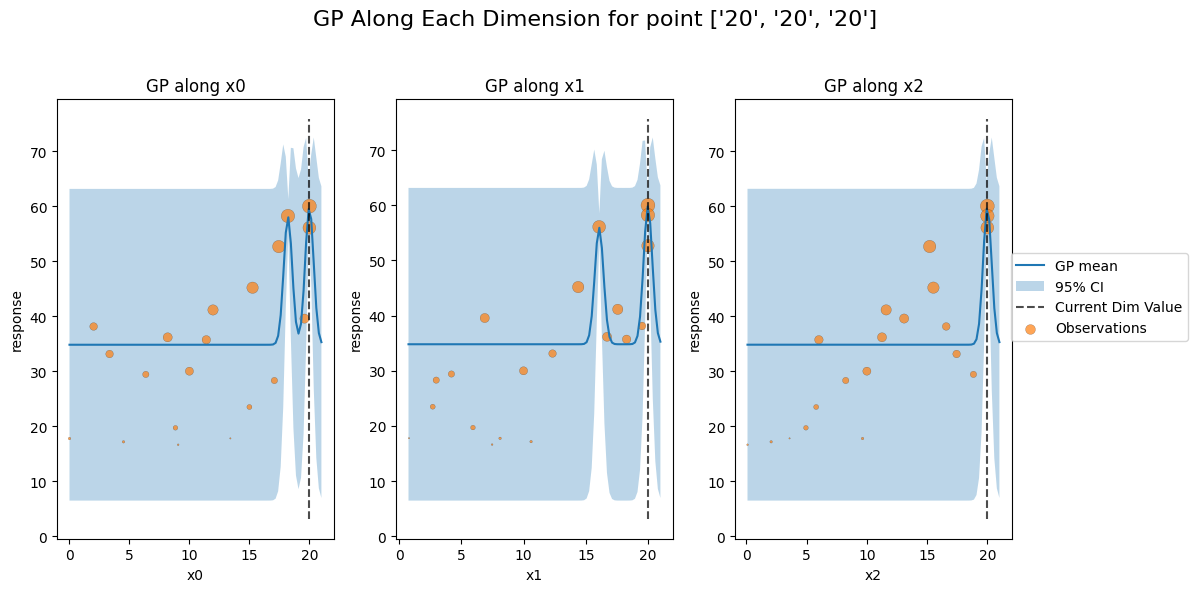

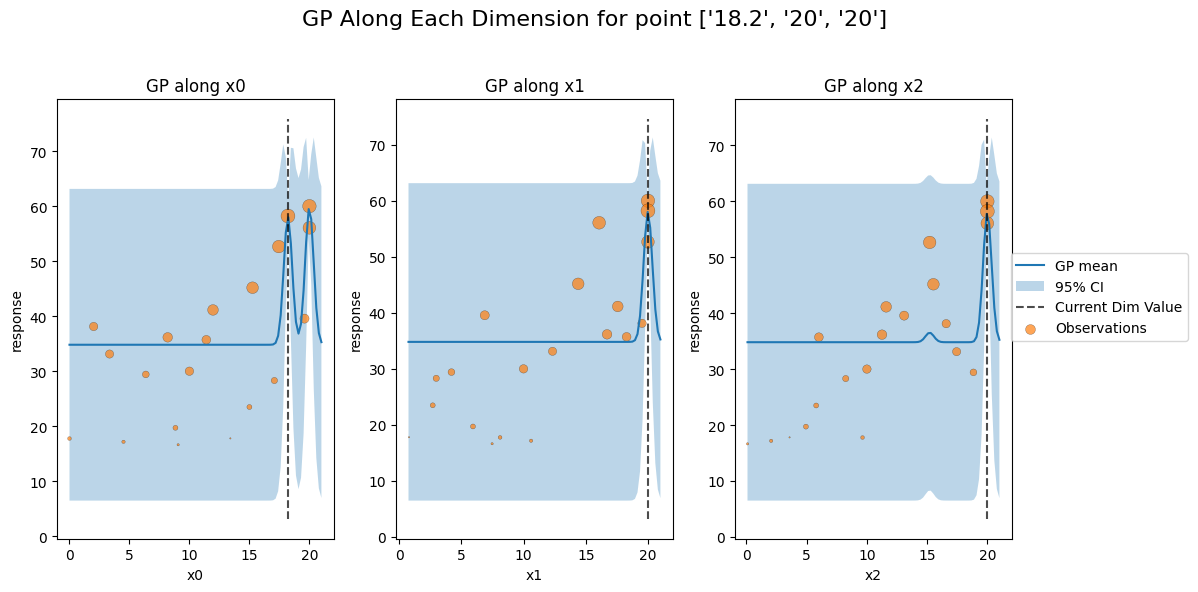

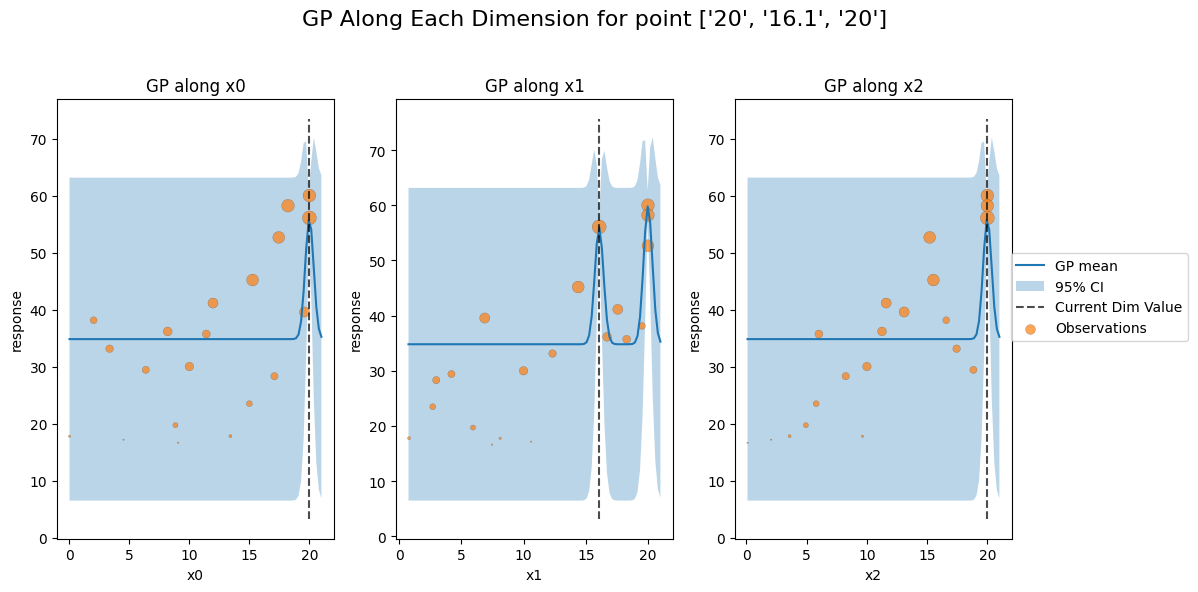

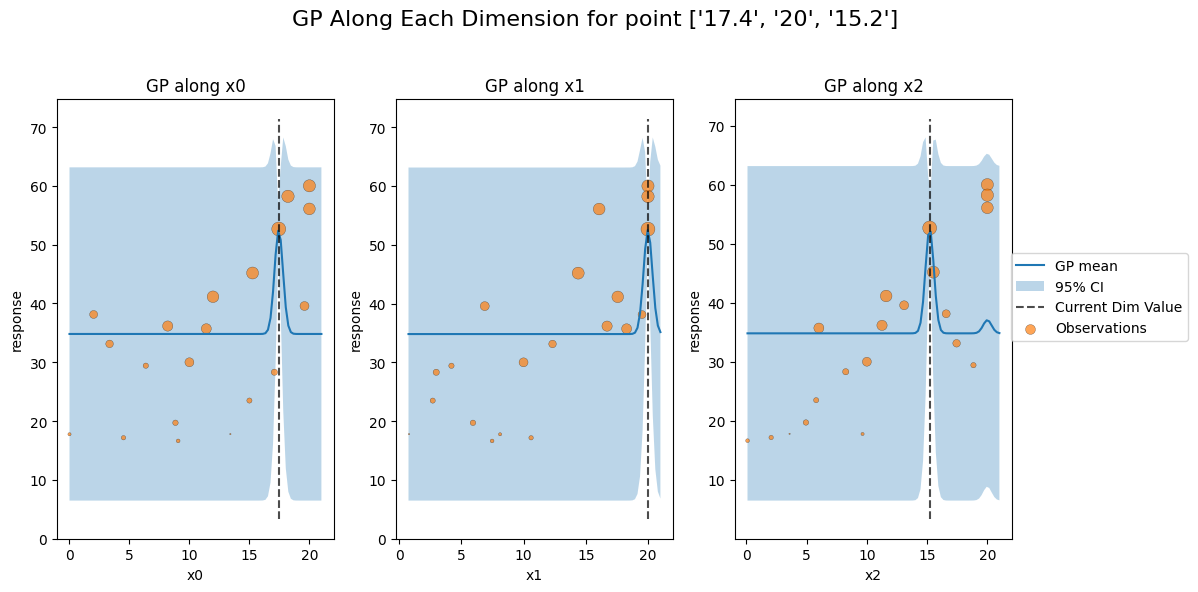

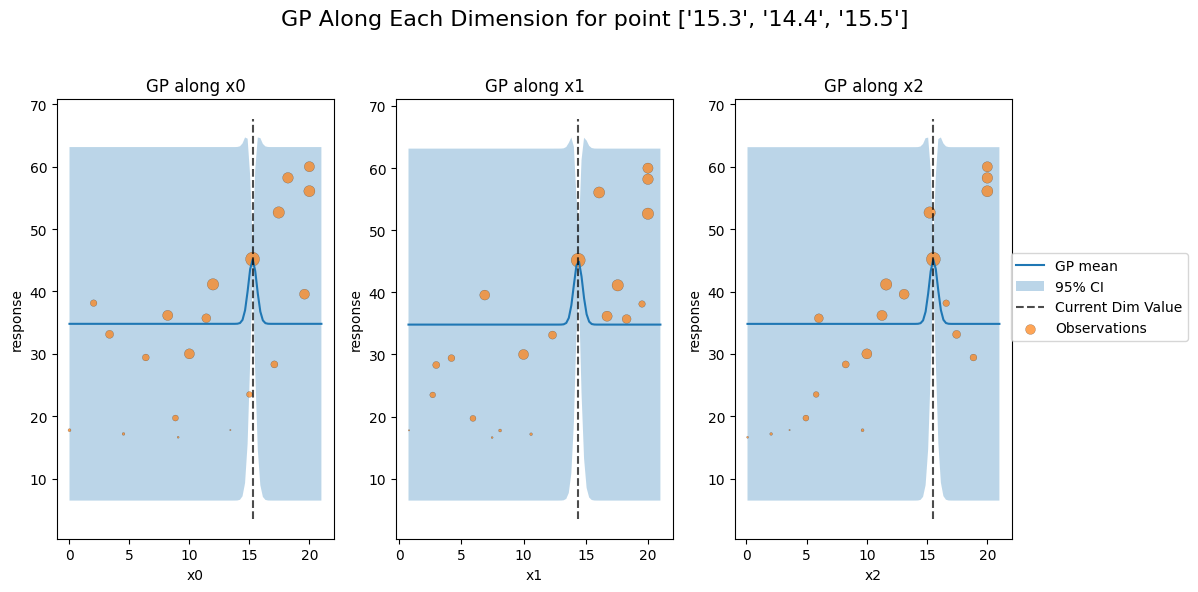

In [9]:
plotter = GPVisualiserMatplotlib(SingleTaskGP, results, list(results.columns[1:4]), "response")


for i in range(5):
    coordinates = results.sort_values(by="response", ascending=False).iloc[i,1:4]
    coordinates = torch.tensor(coordinates, dtype=torch.float64)
    plotter.plot_all(coordinates)
